# Deep Convolutional GANs (DCGAN)

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

## Load data

In [13]:
# load X_train of top10 category
X_train = np.load('/Users/sophiehu/Desktop/SophieHu/MScA/DeepLearning/TaobaoImageRecognition/x_train.npy')
X_train

array([[[[152, 133, 100],
         [147, 128,  95],
         [159, 138, 102],
         ...,
         [223, 225, 214],
         [225, 227, 216],
         [248, 248, 248]],

        [[150, 131,  98],
         [145, 125,  92],
         [157, 136, 100],
         ...,
         [219, 221, 210],
         [219, 221, 210],
         [248, 248, 248]],

        [[148, 129,  96],
         [142, 123,  90],
         [155, 134,  98],
         ...,
         [228, 230, 219],
         [227, 229, 218],
         [248, 248, 248]],

        ...,

        [[ 52,  54,  46],
         [ 37,  39,  23],
         [ 42,  44,  14],
         ...,
         [ 43,  64,  85],
         [ 17,  35,  56],
         [248, 248, 248]],

        [[ 46,  53,  32],
         [ 40,  44,  23],
         [ 53,  56,  34],
         ...,
         [ 78,  97, 119],
         [ 88, 110, 132],
         [248, 248, 248]],

        [[ 55,  66,  36],
         [ 40,  49,  24],
         [ 45,  50,  31],
         ...,
         [ 87, 106, 128],
        

In [14]:
# Load y_train
y_train =  np.load('/Users/sophiehu/Desktop/SophieHu/MScA/DeepLearning/TaobaoImageRecognition/y_train.npy')
y_train

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

In [6]:
X_train = np.load('data/train_images.npy')
y_train = np.load('data/train_labels.npy')
x_val = np.load('data/val_images.npy')
y_val = np.load('data/val_labels.npy')
x_test = np.load('data/test_images.npy')
y_test = np.load('data/test_labels.npy')
x_test.shape

(16847, 128, 128, 3)

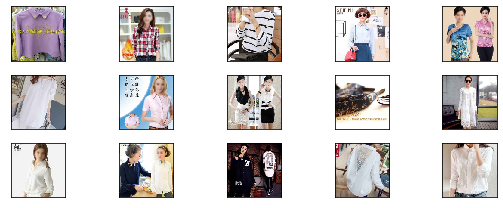

In [15]:
# Explore visual data: RGB data with 10 classes
fig = plt.figure(figsize=(8,3))
for i in range(0, 15):
    plt.subplot(3, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

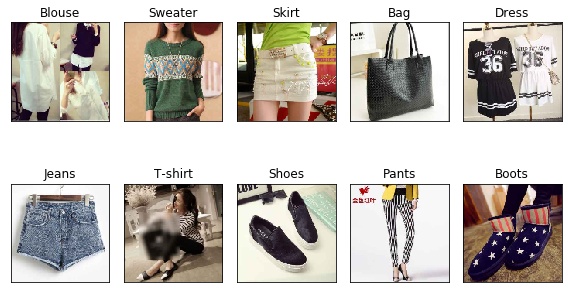

In [63]:
num_classes = len(np.unique(y_train))
class_names = ['Blouse', 'Sweater', 'Skirt', 'Bag', 'Dress', 
                'Jeans', 'T-shirt','Shoes', 'Pants','Boots']
# plot the categories
fig = plt.figure(figsize=(8,5))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

## Reshape and normalize the inputs

In [35]:
# total top10 sample data shape
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'total samples')

X_train shape: (45379, 128, 128, 3)
45379 total samples


In [36]:
# train and test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2,random_state = 42)

In [37]:
# check train and test data shape
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')

x_train shape: (36303, 128, 128, 3)
36303 train samples
x_test shape: (9076, 128, 128, 3)
9076 test samples


In [38]:
# check label shape
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')

y_train shape: (36303, 1)
36303 train samples


In [39]:
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(x_train.shape[0], 3, 128, 128)
    X_test = x_test.reshape(x_test.shape[0], 3, 128, 128=-
    input_shape = (3, 128, 128)
else:
    X_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
    X_test = x_test.reshape(x_test.shape[0], 128, 128, 3)
    input_shape = (128, 128, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using `tanh` activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (36303, 128, 128, 3)
X_test reshape: (36303, 128, 128, 3)


## Define model

### Generator

In [130]:
# latent space dimension
latent_dim = 100
init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

In [131]:
# FC: 4x4x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 1: 4x4x512
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 1: 8x8x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 64x64x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 128x128x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 128x128x64
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 128x128x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [132]:
# prints a summary representation of the denerator model
generator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2048)              206848    
_________________________________________________________________
reshape_13 (Reshape)         (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_68 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 4, 4, 256)       

### Discriminator

In [123]:
img_shape = X_train[0].shape
img_shape

(128, 128, 3)

In [135]:
# depth=64
# input:128x128x3 (depth=1); output: 64x64x3 (depth=64)

# image shape 128x128x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 128x128x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2: 64x64x128
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same',
                  input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 8x8x256
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 4: 4x4x512
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 5: 4x4x1024
discriminator.add(Conv2D(1024, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [136]:
# print a summary representation of discriminator model
discriminator.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_76 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 16, 16, 256)     

## Compile model

In [137]:
# Compile discriminator
# Optimizer
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

Combined network: connect the generator and the discriminator to make a DCGAN

In [138]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [139]:
# prints a summary representation of compiled DCGAN model
d_g.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 128, 128, 3)       6205379   
_________________________________________________________________
sequential_24 (Sequential)   (None, 1)                 17438337  
Total params: 23,643,716
Trainable params: 6,202,883
Non-trainable params: 17,440,833
_________________________________________________________________


## Fit model

epoch = 1/50, d_loss=0.735, g_loss=2.405                                                                                                                        


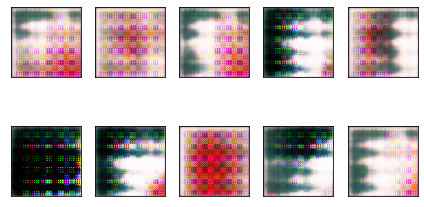

epoch = 2/50, d_loss=0.406, g_loss=1.066                                                                                                                        
epoch = 3/50, d_loss=0.327, g_loss=0.004                                                                                                                        
epoch = 4/50, d_loss=0.176, g_loss=0.053                                                                                                                         
epoch = 5/50, d_loss=0.194, g_loss=0.080                                                                                                                        
epoch = 6/50, d_loss=0.181, g_loss=0.090                                                                                                                        
epoch = 7/50, d_loss=0.179, g_loss=0.083                                                                                                                         
epoch = 8/50, d_loss=0.172, g_lo

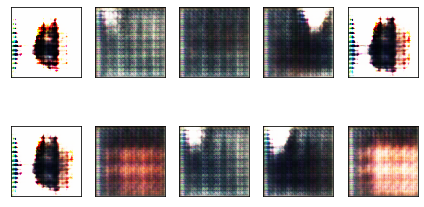

epoch = 12/50, d_loss=0.171, g_loss=1.325                                                                                                                         
epoch = 13/50, d_loss=0.201, g_loss=1.043                                                                                                                        
epoch = 14/50, d_loss=0.173, g_loss=0.452                                                                                                                        
epoch = 15/50, d_loss=0.176, g_loss=0.111                                                                                                                         
epoch = 16/50, d_loss=0.250, g_loss=0.659                                                                                                                         
epoch = 17/50, d_loss=0.184, g_loss=0.082                                                                                                                        
epoch = 18/50, d_loss=0.1

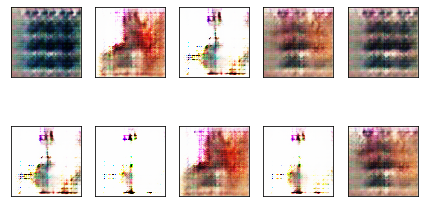

epoch = 22/50, d_loss=0.175, g_loss=0.121                                                                                                                        
epoch = 23/50, d_loss=0.167, g_loss=0.153                                                                                                                        
epoch = 24/50, d_loss=0.168, g_loss=2.336                                                                                                                         
epoch = 25/50, d_loss=0.180, g_loss=0.852                                                                                                                         
epoch = 26/50, d_loss=0.171, g_loss=0.159                                                                                                                        
epoch = 27/50, d_loss=0.175, g_loss=0.181                                                                                                                         
epoch = 28/50, d_loss=0.1

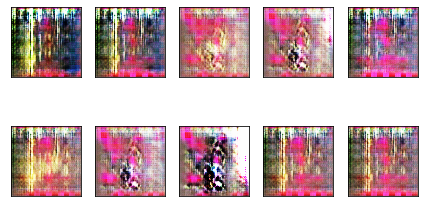

epoch = 32/50, d_loss=0.171, g_loss=0.375                                                                                                                        
epoch = 33/50, d_loss=0.168, g_loss=0.140                                                                                                                        
epoch = 34/50, d_loss=0.167, g_loss=0.058                                                                                                                        
epoch = 35/50, d_loss=0.172, g_loss=0.776                                                                                                                        
epoch = 36/50, d_loss=0.169, g_loss=0.129                                                                                                                        
epoch = 37/50, d_loss=0.172, g_loss=0.065                                                                                                                        
epoch = 38/50, d_loss=0.171,

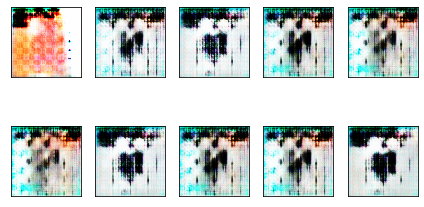

epoch = 42/50, d_loss=0.177, g_loss=0.284                                                                                                                         
epoch = 43/50, d_loss=0.173, g_loss=0.150                                                                                                                         
epoch = 44/50, d_loss=0.169, g_loss=0.119                                                                                                                        
epoch = 45/50, d_loss=0.165, g_loss=0.138                                                                                                                         
epoch = 46/50, d_loss=0.166, g_loss=0.091                                                                                                                        
epoch = 47/50, d_loss=0.165, g_loss=0.202                                                                                                                        
epoch = 48/50, d_loss=0.1

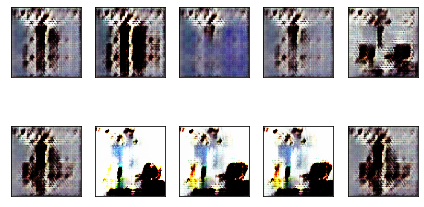

In [141]:
epochs = 50
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print('epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r')
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

## Evaluate model

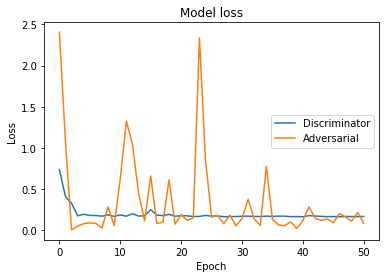

In [142]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()